In [45]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab
from pathlib import Path
from collections import Counter
import pickle
import joblib
import operator


import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, make_scorer

# 1) Loading data

In [2]:
path_data = Path('data')

filepath_data = path_data / 'device_failure.csv'

In [3]:
df = pd.read_csv(filepath_data, encoding = "ISO-8859-1")
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [4]:
df['date'] = pd.to_datetime(df['date'])

# 2) Exploratory Analysis

In [5]:
def count_labels(labels):
    neg, pos = np.bincount(labels)
    total = neg + pos
    print('Examples\n    Total: {}\n    Failure: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))

In [6]:
count_labels(df['failure'])

Examples
    Total: 124494
    Failure: 106 (0.09% of total)



Text(0.5, 1.0, 'Active devices by day')

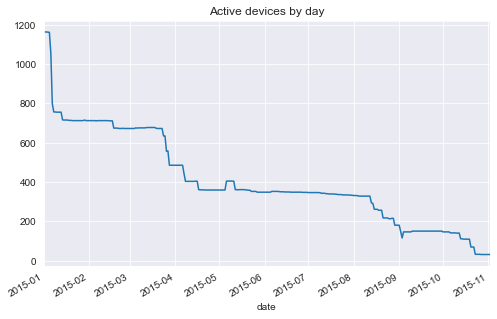

In [7]:
ax = df.groupby('date')['device'].nunique('device').plot(figsize=(8,5))
ax.set_title('Active devices by day')

In [8]:
attributes_cols = ['attribute1','attribute2', 'attribute3', 'attribute4', 'attribute5',
            'attribute6', 'attribute7', 'attribute8', 'attribute9']

### 2.b Variable distribution

In [9]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(6,3))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)
    plt.title('{}'.format(variable))
    plt.show()

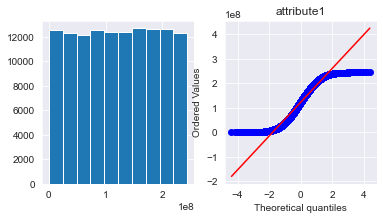

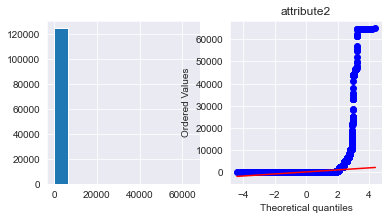

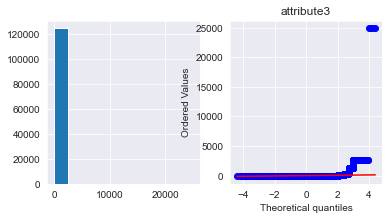

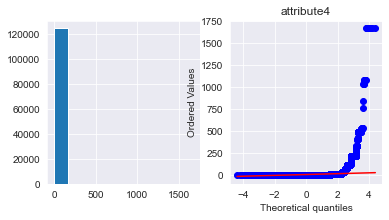

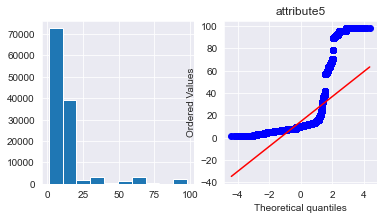

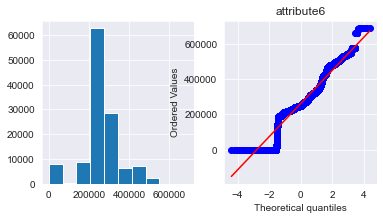

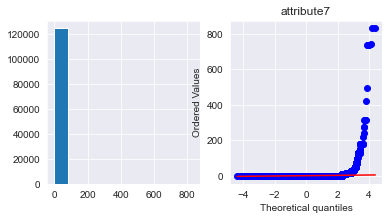

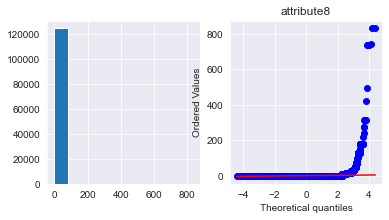

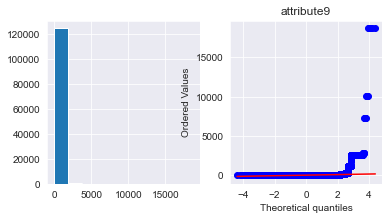

In [10]:
for att in attributes_cols:
    diagnostic_plots(df, att)

Points in Attributes 2, 3, 4, 7, 8 and 9  follow a strongly nonlinear pattern, suggesting that the data are not distributed as a standard normal

### 2.c Interaction between variables

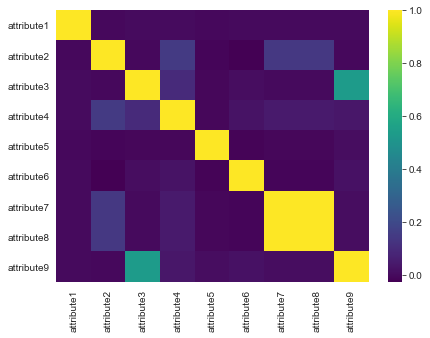

In [11]:
f, ax = plt.subplots(figsize=(7, 5))
corr = df[attributes_cols].corr()
sns.heatmap(corr,
            cmap='viridis',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [12]:
attributes_cols.remove('attribute8')

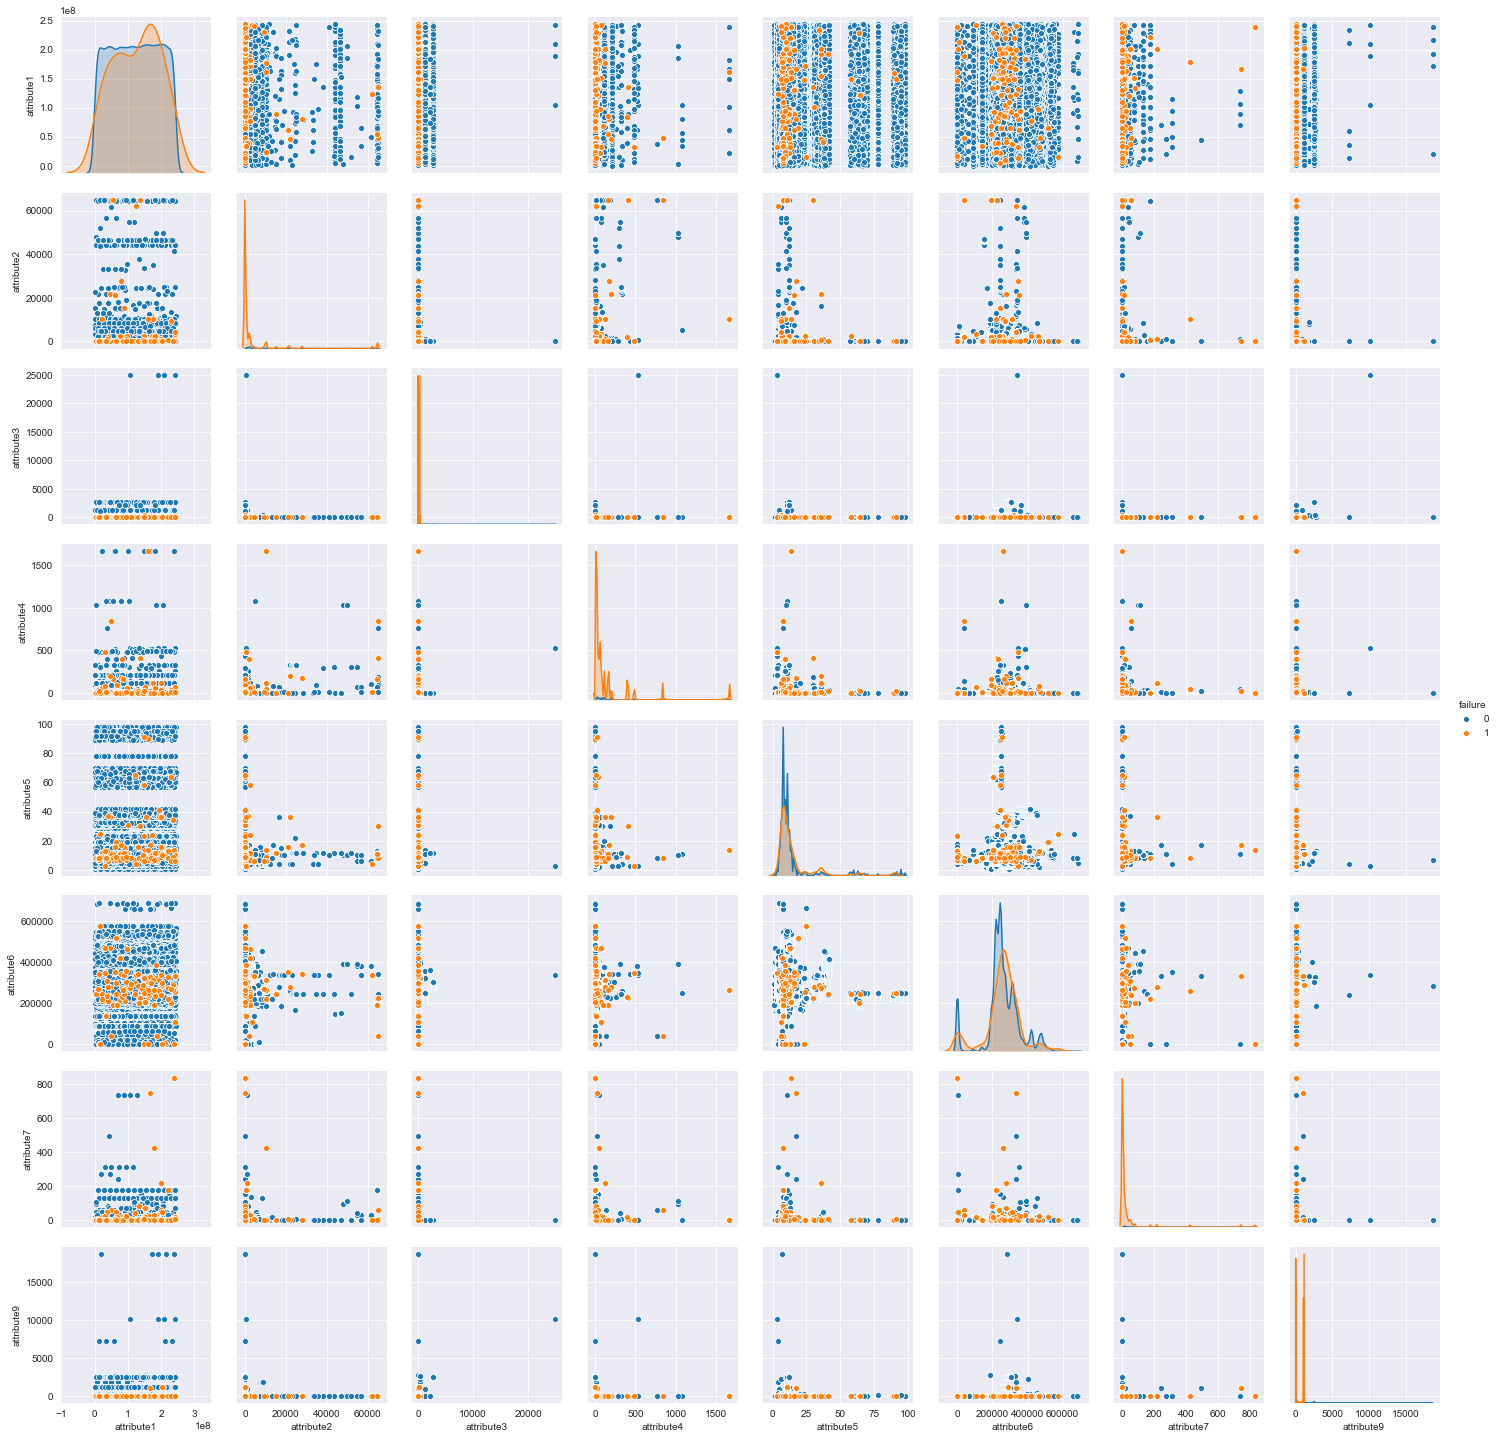

In [13]:
sns.pairplot(df, vars = attributes_cols, hue='failure');

### 2.d Devices activity through time

In [15]:
def plot_timeline(df):
    
    dataset = [(row[0], row[1], row[2]) for idx,row in df[['date','device', 'failure']].iterrows()]
    
    size = {1: 8, 0: 4} 
    colors = {1: 'r', 0: 'lightblue'}   
    series  = set([])                      

    for _, source, category in dataset:
        series.add(source)
        if category not in colors:
            colors[category] = 'k'

    series  = sorted(list(series))

    x = []  
    y = []  
    c = []  
    s = []  
    
    for timestamp, source, category in dataset:
        x.append(timestamp)
        y.append(series.index(source))
        c.append(colors[category])
        s.append(size[category])
        
    figsize = (8,15)
    plt.figure(figsize=(15,20))
    plt.title('Time Plot')
    plt.ylim((-1,len(series)))
    plt.xlim((dataset[0][0], dataset[-1][0]))
    plt.yticks([])
    plt.scatter(x, y, color=c, alpha=0.5, s=s)

    return plt

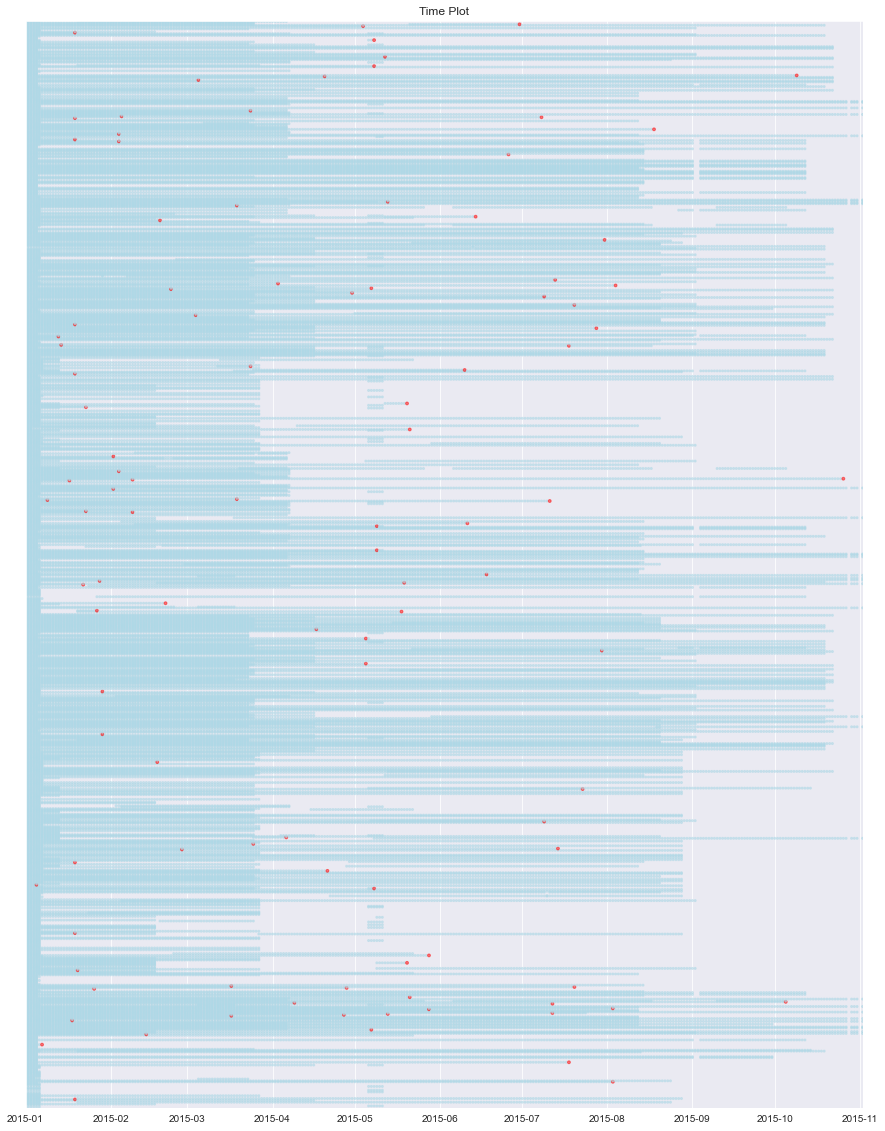

In [17]:
plt = plot_timeline(df)
plt.show()

## Observations on data:

- No missing values
- Imablanced (0.09% of total positive)
- 1 duplicates rows
- Attributes 2, 3, 4, 7, 8 and 9 are highly skewed
- Attributes 2, 3, 4, 7, 8 and 9 are mostly zeros (>90%)
- Atributes 7 and 8 are the same
- Attributes 1 and 6 poorly correlated with failure
- Attribute 3 and 9 highly correlated with failure

- 1169 devices are active intermittently with different lifetime
- 304 unique days in data

# 3) Feature Engineering

In [18]:
attributes_cols = [x for x in attributes_cols if x != 'attribute8'] # delete Attribute8 from list
device_cols = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6']

In [19]:
def preprocess_df(df):
    
    clean_df = df.copy()
    
    clean_df = clean_df.drop_duplicates()
    
    # Create some features
    clean_df['active days'] = clean_df.groupby('device')['date'].apply(lambda x: x - 
                                                                       x.min()).astype('int')/86400000000000
    clean_df['D1'] = clean_df['device'].map(lambda x: x[:2])
    clean_df['D2'] = clean_df['device'].map(lambda x: x[2:4])
    clean_df['D3'] = clean_df['device'].map(lambda x: x[4:5])
    clean_df['D4'] = clean_df['device'].map(lambda x: x[5:6])
    clean_df['D5'] = clean_df['device'].map(lambda x: x[6:7])
    clean_df['D6'] = clean_df['device'].map(lambda x: x[7:8])
    
    # Transform features in log scale
    for att in attributes_cols:
        clean_df[att] = np.log(clean_df[att] + 1)
        
    # Delete irrelevant columns
    del clean_df['attribute8']
    del clean_df['device']
    del clean_df['date']
    

    return clean_df

In [20]:
def data_pipeline(df, scaler=None, encoder=None):
    
    # create 'attribute' features
    attributes = df[attributes_cols].to_numpy()
    
    if not scaler:
        scaler = StandardScaler()
        attributes = scaler.fit_transform(attributes)
        
        # dump encoder so I can reuse it later
        joblib.dump(scaler, 'scaler.joblib')
        
    else:
        attributes = scaler.transform(attributes)
        
    # create 'active days' feature
    active_days = df['active days'].to_numpy()
    active_days = active_days.reshape(active_days.shape[0], 1)

    # one hot encoding of 'device features'
    devices = df[device_cols].to_numpy()
    
    if not encoder:
        encoder = OneHotEncoder(handle_unknown='ignore')
        devices = encoder.fit_transform(devices).toarray()
        
        # dump encoder so I can reuse it later
        joblib.dump(encoder, 'ohencoder.joblib')
        
        # check that the number of one hot encoded features are OK
        tot = 0
        
        for col in device_cols:
            tot += df[col].nunique() 

        if not tot == devices.shape[1]:
            raise ValueError("Wrong encoding of device's features")
            
    else:
        devices = encoder.transform(devices).toarray()
    
        
    # Concatenate feature
    X = np.hstack((attributes, active_days, devices))
    
    # Create labels
    y = y = df['failure'].to_numpy()
    
    return X, y

In [21]:
clean_df = preprocess_df(df)

In [22]:
train_df, test_df = train_test_split(clean_df, test_size=0.3, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=42)

In [23]:
X_train, y_train = data_pipeline(train_df)

scaler = joblib.load('scaler.joblib')
enc = joblib.load('ohencoder.joblib')

X_val, y_val = data_pipeline(val_df, scaler, enc)
X_test, y_test = data_pipeline(test_df, scaler,  enc)

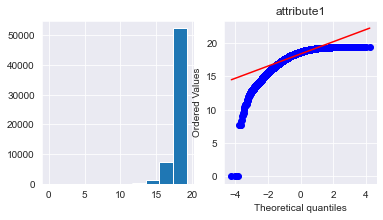

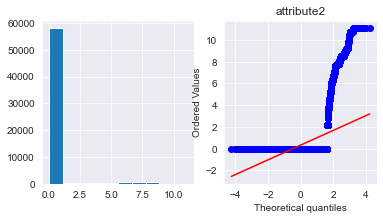

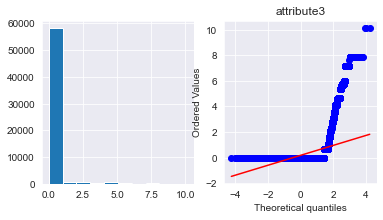

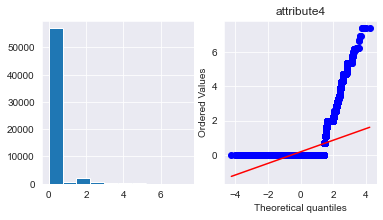

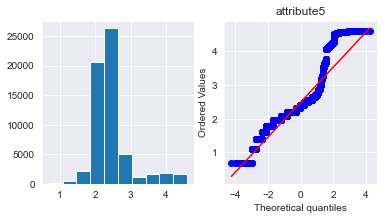

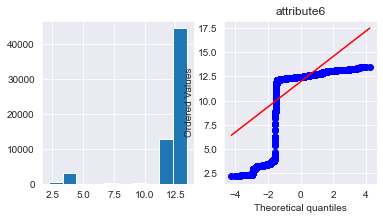

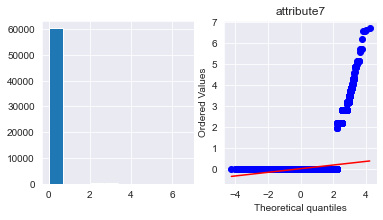

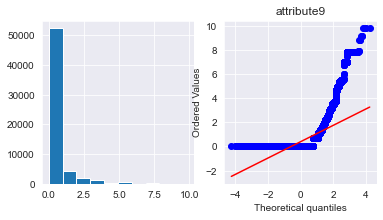

In [24]:
for att in attributes_cols:
    diagnostic_plots(train_df, att)

# 4) Training and model selection

In [25]:
count_labels(y_train)

Examples
    Total: 61001
    Failure: 54 (0.09% of total)



In [26]:
count_labels(y_test)

Examples
    Total: 37348
    Failure: 29 (0.08% of total)



Labels are highly imbalanced, we make two approaches:
    
    - over sampling
    - weight rescaling in loss (objective) funciton

### 4.a Oversampling and Undersampling

In [27]:
from imblearn.under_sampling import TomekLinks, ClusterCentroids


# Over Sampling
ROS = RandomOverSampler(random_state=0)
SM = SMOTE()
BLSM = BorderlineSMOTE()
ADA = ADASYN()

# Under Sampling
#us = TomekLinks()
#us = RandomUnderSampler()
#us = ClusterCentroids(random_state=42)

X_train_ros, y_train_ros = ROS.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = SM.fit_resample(X_train, y_train)
X_train_blsm, y_train_blsm = BLSM.fit_resample(X_train, y_train)
X_train_ada, y_train_ada = ADA.fit_resample(X_train, y_train)

In [28]:
count_labels(y_train_ros)

Examples
    Total: 121894
    Failure: 60947 (50.00% of total)



### 4.b rescaling weights

In [29]:
def scale_pos_weight(labels):
    
    counter = Counter(labels)
    estimate = counter[0] / counter[1]
    
    return estimate

In [30]:
scale_weight = scale_pos_weight(y_train)
print('Estimate: %.3f' % scale_weight)

Estimate: 1128.648


### 4.c Utile functions

In [131]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [64]:
def get_features_importance(features, model):
    
    features_importeance=dict()
    
    i=0
    for feature, importance in zip(features, model.feature_importances_):
        if feature in features_importeance.keys():
            features_importeance[feature+'_{}'.format(i)] = importance
            i=i+1
        else:
            features_importeance[feature]=importance
    
    features_importeance = dict(sorted(features_importeance.items(), key=operator.itemgetter(1), reverse=True))
    
    return features_importeance

In [35]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100])
    plt.ylim([0,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [36]:
def evaluate(labels, predictions):
    
    accuracy = accuracy_score(labels, np.round(predictions))
    precision = precision_score(labels, np.round(predictions))
    recall = recall_score(labels, np.round(predictions))
    f1 = f1_score(labels, np.round(predictions))
    roc_auc = roc_auc_score(labels, predictions)
    
    return {'acc': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc auc': roc_auc}

### 4.d Model Selection 

Training with Random Over Sampling:
Training with SMOTE:
Training with Border Line Smote:
Training with ADASYN:
Training with scale weight: 1
Training with scale weight: 5
Training with scale weight: 100
Training with scale weight: 1128.648148148148


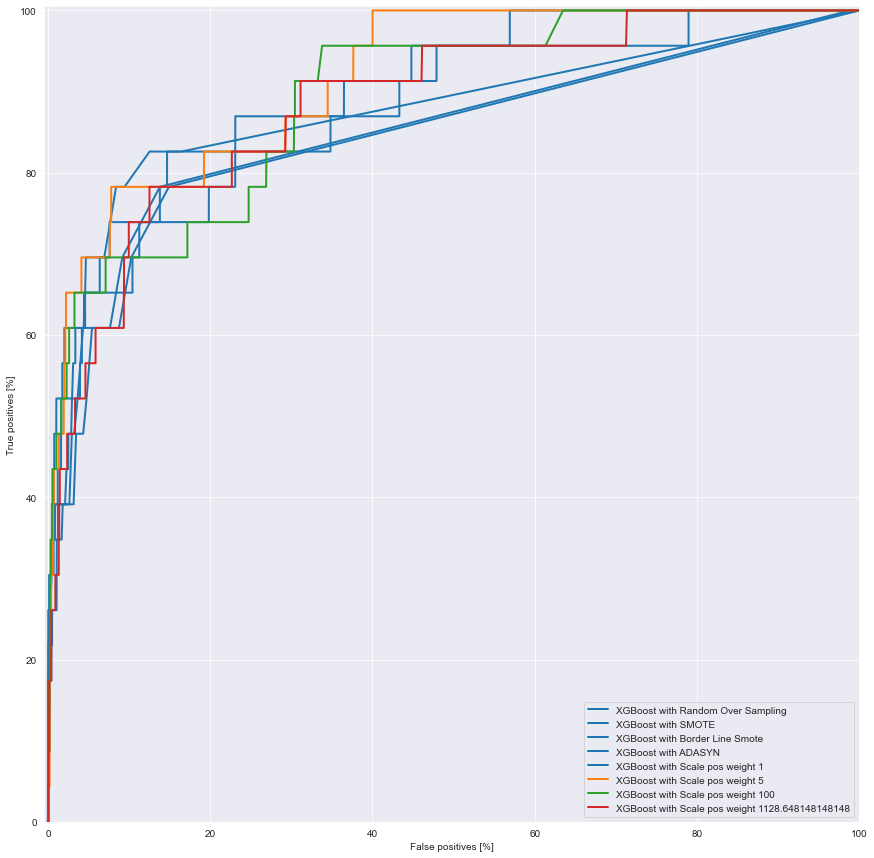

In [38]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

eval_set = [(X_val, y_val)]

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scoring = 'auc' #f1_eval
gamma=0.2

results = dict()
i=0

plt.figure(figsize=(15,15))

ros_model = XGBClassifier(gamma=gamma, max_depth=7, min_child_weight=7, scale_pos_weight= 1)
print('Training with Random Over Sampling:')
ros_model.fit(X_train_ros, y_train_ros, eval_metric=scoring, early_stopping_rounds=10, eval_set=eval_set, verbose=False)
y_pred = ros_model.predict_proba(X_val)[:,1]
results['ROS'] = evaluate(y_val, y_pred)
plot_roc("XGBoost with Random Over Sampling", y_val, y_pred, color=colors[i])

sm_model = XGBClassifier(gamma=gamma, max_depth=7, min_child_weight=7, scale_pos_weight= 1)
print('Training with SMOTE:')
sm_model.fit(X_train_sm, y_train_sm, eval_metric=scoring, early_stopping_rounds=10, eval_set=eval_set, verbose=False)
y_pred = sm_model.predict_proba(X_val)[:,1]
results['SMOTE'] = evaluate(y_val, y_pred)
plot_roc("XGBoost with SMOTE", y_val, y_pred, color=colors[i])

blsm_model = XGBClassifier(gamma=gamma, max_depth=7, min_child_weight=7, scale_pos_weight= 1)
print('Training with Border Line Smote:')
blsm_model.fit(X_train_blsm, y_train_blsm, eval_metric=scoring, early_stopping_rounds=10, eval_set=eval_set, verbose=False)
y_pred = blsm_model.predict_proba(X_val)[:,1]
results['BL SMOTE'] = evaluate(y_val, y_pred)
plot_roc("XGBoost with Border Line Smote", y_val, y_pred, color=colors[i])

ada_model = XGBClassifier(gamma=gamma, max_depth=7, min_child_weight=7, scale_pos_weight= 1)
print('Training with ADASYN:')
ada_model.fit(X_train_ada, y_train_ada, eval_metric=scoring, early_stopping_rounds=10, eval_set=eval_set, verbose=False)
y_pred = ada_model.predict_proba(X_val)[:,1]
results['ADASYIN'] = evaluate(y_val, y_pred)
plot_roc("XGBoost with ADASYN", y_val, y_pred, color=colors[i])

weights = [1, 5, 100, scale_weight]

for w in weights: 
    
    model = XGBClassifier(gamma=gamma, max_depth=7, min_child_weight=7, scale_pos_weight= w)
    print('Training with scale weight: {}'.format(w))
    model.fit(X_train, y_train, eval_metric=scoring, early_stopping_rounds=10, eval_set=eval_set, verbose=False)
    y_pred = model.predict_proba(X_val)[:,1]
    results['W={}'.format(w)] = evaluate(y_val, y_pred)
    plot_roc("XGBoost with Scale pos weight {}".format(w), y_val, y_pred, color=colors[i])
    
    i += 1
    
plt.legend(loc='lower right')

plt.show()

In [39]:
pd.DataFrame(results)

,ROS,SMOTE,BL SMOTE,ADASYIN,W=1,W=5,W=100,W=1128.648148148148
acc,0.997743,0.986383,0.998776,0.992656,0.999120,0.999006,0.998011,0.995946
precision,0.125000,0.022923,0.235294,0.043243,0.000000,0.000000,0.060606,0.043956
recall,0.260870,0.347826,0.173913,0.347826,0.000000,0.000000,0.086957,0.173913
f1,0.169014,0.043011,0.200000,0.076923,0.000000,0.000000,0.071429,0.070175
roc auc,0.885257,0.845186,0.895110,0.851778,0.875118,0.915757,0.892956,0.885054


### 4.e Regularization (Gridsearch gamma parameter)

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


model = XGBClassifier()

eval_set = [(X_val, y_val)]

param_grid = {
 'max_depth': [7],
 'min_child_weight': [7], 
 'gamma':[i/10.0 for i in range(0,10, 2)],
 'scale_pos_weight': [1]
}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc', verbose=3)
grid_result = grid.fit(X_train_blsm, y_train_blsm)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  7.5min finished


Best: 0.999914 using {'gamma': 0.8, 'max_depth': 7, 'min_child_weight': 7, 'scale_pos_weight': 1}
0.999908 (0.000016) with: {'gamma': 0.0, 'max_depth': 7, 'min_child_weight': 7, 'scale_pos_weight': 1}
0.999902 (0.000023) with: {'gamma': 0.2, 'max_depth': 7, 'min_child_weight': 7, 'scale_pos_weight': 1}
0.999905 (0.000020) with: {'gamma': 0.4, 'max_depth': 7, 'min_child_weight': 7, 'scale_pos_weight': 1}
0.999900 (0.000022) with: {'gamma': 0.6, 'max_depth': 7, 'min_child_weight': 7, 'scale_pos_weight': 1}
0.999914 (0.000015) with: {'gamma': 0.8, 'max_depth': 7, 'min_child_weight': 7, 'scale_pos_weight': 1}


### 4.f Feature importance

In [145]:
eval_set = [(X_val, y_val)]
best_model = XGBClassifier(**grid_result.best_params_)
best_model.fit(X_train_blsm, y_train_blsm, eval_metric='auc', early_stopping_rounds=10, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.8, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [158]:
categories = [item for sublist in enc.categories_ for item in sublist]

features = attributes_cols + ['active days'] + categories

features_importeance = get_features_importance(features, best_model)

In [159]:
features_importeance

{'attribute7': 0.51620483,
 '0_0': 0.3377378,
 'attribute4': 0.047108512,
 'D_46': 0.013568182,
 'active days': 0.008870261,
 '0_33': 0.008235095,
 'C': 0.0073308544,
 'X_96': 0.006638317,
 'S': 0.0059333052,
 '5_38': 0.004168404,
 'Q': 0.0040299855,
 '3_3': 0.004009444,
 'W_95': 0.0034225981,
 'X': 0.0033809664,
 'V_28': 0.0031225767,
 'D_13': 0.0030612282,
 'V_94': 0.002427328,
 'J_51': 0.002071591,
 'K_19': 0.0019632285,
 '6_6': 0.0017359994,
 '0_66': 0.0015740574,
 '5_5': 0.0015441997,
 '1_67': 0.0014552673,
 'L': 0.001131235,
 '4_70': 0.0009108684,
 'C_78': 0.0008543866,
 '3': 0.00075722934,
 '2': 0.0006765338,
 '4_4': 0.00067538343,
 '6': 0.00062361173,
 'F0': 0.000614881,
 'Z1': 0.0005299074,
 'H_50': 0.00048824385,
 'attribute5': 0.00044922926,
 'S1': 0.00040702824,
 'attribute2': 0.0003906486,
 'attribute9': 0.00038264244,
 'F': 0.00034783772,
 'W1': 0.00034039543,
 '5_71': 0.00030583813,
 'attribute6': 0.00028148363,
 'attribute1': 0.00023854832,
 'attribute3': 0.0,
 'F1': 0.

### 5) Model Evaluation

In [160]:
y_pred = best_model.predict_proba(X_test)[:,1]

In [161]:
def clas_report(model, features, labels):
    
    predictions = model.predict(features)
    
    report = pd.DataFrame(classification_report(labels, predictions, output_dict=True)).transpose()
    return report

In [162]:
clas_report(grid_result, X_test, y_test)

,precision,recall,f1-score,support
0,0.999304,0.999652,0.999478,37319.000000
1,0.187500,0.103448,0.133333,29.000000
accuracy,0.998956,0.998956,0.998956,0.998956
macro avg,0.593402,0.551550,0.566405,37348.000000
weighted avg,0.998673,0.998956,0.998805,37348.000000


In [163]:
def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [164]:
def Find_Optimal_Cutoff(target, predicted):

    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

Area under the ROC curve : 0.914008


[]

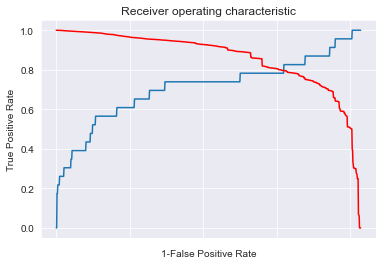

In [165]:
from sklearn.metrics import roc_curve, auc

# Find optimal probability threshold
y_pred_val = best_model.predict_proba(X_val)[:,1]
threshold = Find_Optimal_Cutoff(y_val, y_pred_val)

fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)


i = np.arange(len(tpr)) 
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]


fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])




Legitimate Transactions Detected (True Negatives):  60928
Legitimate Transactions Incorrectly Detected (False Positives):  19
Fraudulent Transactions Missed (False Negatives):  44
Fraudulent Transactions Detected (True Positives):  60903
Total Fraudulent Transactions:  60947


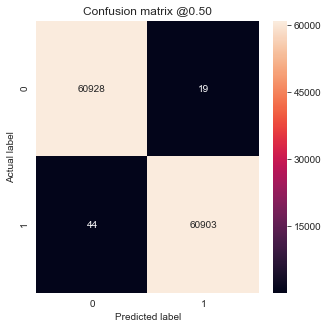

In [166]:
y_pred_train = best_model.predict_proba(X_train_blsm)[:,1]

plot_cm(y_train_blsm, y_pred_train)

Legitimate Transactions Detected (True Negatives):  37298
Legitimate Transactions Incorrectly Detected (False Positives):  21
Fraudulent Transactions Missed (False Negatives):  25
Fraudulent Transactions Detected (True Positives):  4
Total Fraudulent Transactions:  29


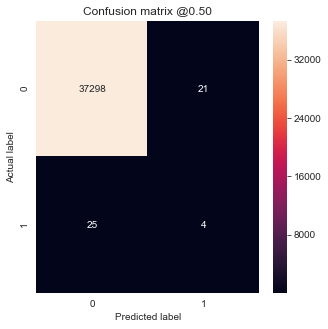

In [167]:
plot_cm(y_test, y_pred)

In [168]:
threshold

[0.0006498945294879377]

Legitimate Transactions Detected (True Negatives):  29702
Legitimate Transactions Incorrectly Detected (False Positives):  7617
Fraudulent Transactions Missed (False Negatives):  6
Fraudulent Transactions Detected (True Positives):  23
Total Fraudulent Transactions:  29


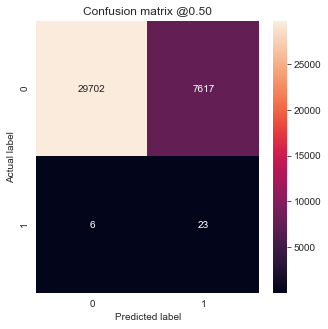

In [169]:
plot_cm(y_test, np.array([1 if x > threshold else 0 for x in y_pred]))

# 6) Conclusions

The selected model performs almost perfect in training data, as it manages imbalance data appropiately (thanks to BLSM oversampling). However, performance with test (unseen) data is very poor, as it 21 FP and 25 FN. 

In my view, for this task FN are far more important to acess than FP, as missclassifying a device as not failure, when actually is about to fail , would incur in much cost than the viceversa, that is when we classify a device as failure when it is not (FP), incurring only in operational costs.